In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")
print("Path to dataset files:", path)
from google.colab import drive
drive.mount('/content/drive')

100%|██████████| 230M/230M [00:01<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chethuhn/network-intrusion-dataset/versions/1
Mounted at /content/drive


In [2]:
import os
kaggle_path = '/root/.cache/kagglehub/datasets/chethuhn/network-intrusion-dataset/versions/1'
for file in os.listdir(kaggle_path):
  print(file)

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv


In [3]:
import os
import shutil
kaggle_folder = '/root/.cache/kagglehub/datasets/chethuhn/network-intrusion-dataset/versions/1'
drive_folder = '/content/drive/MyDrive/CICIDS2017_Parts'
# Create the folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)
# Copy all CSVs
for file in os.listdir(kaggle_folder):
  if file.endswith('.csv'):
    shutil.copy(os.path.join(kaggle_folder, file), os.path.join(drive_folder, file))

In [4]:
import pandas as pd
import glob
csv_files = glob.glob('/content/drive/MyDrive/CICIDS2017_Parts/*.csv')
# Read and concatenate all CSVs
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
# Preview
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
# Drop rows with missing values
data = df.dropna()

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# Separate features (X) and labels (y)
X = df.drop(' Label', axis=1)
y = df[' Label']
# 1. Drop any negative values (e.g., Flow Duration shouldn't be negative)
X = X[(X >= 0).all(axis=1)]
# 2. Drop rows with very large values (e.g., > 1e8 = 100 million)
threshold = 1e8
X = X[(X < threshold).all(axis=1)]
# 3. Update labels to match
y = y.loc[X.index]
# 4. Now it's safe to normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 5. Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.2, random_state=42
)

In [18]:
#Build the Deep Feedforward Neural Network. We'll use TensorFlow/Keras to build the model.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# Define the model
model = Sequential()
# Input layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

In [26]:
#Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2)) # Dropout for regularization
model.add(Dense(32, activation='relu'))

# --- Label Encoding and Model Update for Multiclass Classification ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd # Import pandas to use concat and unique

# Encode string labels to integers
label_encoder = LabelEncoder()
# Fit the encoder on the combined unique labels from both train and test sets
label_encoder.fit(pd.concat([y_train, y_test]).unique())
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert integer labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Output layer for multiclass classification
# Remove the old output layer and add a new one
model.pop() # Remove the old Dense(1, activation='sigmoid') layer
model.add(Dense(num_classes, activation='softmax')) # Softmax activation for multiclass

# Compile the model for multiclass classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Categorical crossentropy loss
# --- End of Label Encoding and Model Update ---

# Print the model summary
model.summary()

#Train the model
# Train the model
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_split=0.2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         2,11

 Total params: 34,740 (135.70 KB)

 Trainable params: 34,740 (135.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.7453 - loss: 0.7235 - val_accuracy: 0.7691 - val_loss: 0.5989
Epoch 2/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7703 - loss: 0.6150 - val_accuracy: 0.7774 - val_loss: 0.6505
Epoch 3/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.7752 - loss: 0.6766 - val_accuracy: 0.7766 - val_loss: 0.6522
Epoch 4/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - accuracy: 0.7754 - loss: 0.6583 - val_accuracy: 0.7773 - val_loss: 0.6495
Epoch 5/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.7767 - loss: 0.6532 - val_accuracy: 0.7777 - val_loss: 0.6474
Epoch 6/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.7775 - loss: 0.6517 - val_accuracy: 0.7773 - val_loss: 0.6494
Epoch 7/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.7717 - loss: 0.7074 - val_accuracy: 0.7657 - val_loss: 0.8182
Epoch 8/10
12348/12348 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 

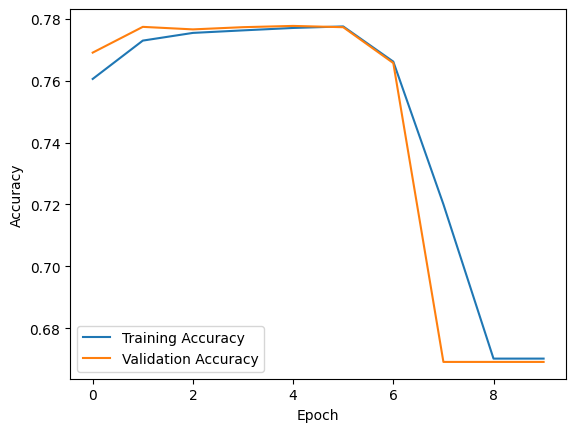

In [27]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
#Evaluate the model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd

# Re-perform label encoding to ensure label_encoder and y_test_categorical are available
# Assuming y_test is available from previous steps
label_encoder = LabelEncoder()
if 'y' in locals():
    label_encoder.fit(y.unique())
elif 'y_train' in locals() and 'y_test' in locals():
    label_encoder.fit(pd.concat([y_train, y_test]).unique())
else:
    print("Warning: y, y_train, or y_test not found. Cannot perform label encoding for evaluation.")
    # Depending on the state, you might need to add code here to load/prepare data if necessary.

if 'y_test_categorical' not in locals() and 'y_test' in locals() and 'label_encoder' in locals():
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)
elif 'y_test_categorical' not in locals():
     print("Warning: y_test_categorical not found. Cannot perform evaluation.")

# Evaluate the model using categorical labels
if 'model' in locals() and 'X_test' in locals() and 'y_test_categorical' in locals():
    loss, accuracy = model.evaluate(X_test, y_test_categorical)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    # Predict on test data
    y_pred_probs = model.predict(X_test) # Get probability distributions
    # Convert probabilities to predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Convert predicted indices back to original labels for confusion matrix and classification report
    if 'label_encoder' in locals():
        y_pred_labels = label_encoder.inverse_transform(y_pred)
    else:
        y_pred_labels = y_pred # Use numerical predictions if encoder not available
        print("Warning: label_encoder not available to inverse transform predictions.")

    # Confusion matrix
    if 'y_test' in locals() and 'y_pred_labels' in locals():
        conf_matrix = confusion_matrix(y_test, y_pred_labels)
        print('Confusion Matrix:')
        print(conf_matrix)

        # Classification report
        print('Classification Report:')
        print(classification_report(y_test, y_pred_labels))
    else:
        print("Warning: y_test or y_pred_labels not available for confusion matrix and classification report.")

else:
    print("Warning: model, X_test, or y_test_categorical not available for evaluation.")

#Save the model for future use
if 'model' in locals():
    model.save('/content/drive/MyDrive/cyber_security_model.h5')
    print("Model saved successfully.")
else:
    print("Warning: Model not found, cannot save.")

#You can load the saved model and use it for predictions.
from tensorflow.keras.models import load_model
# Load the model
try:
    loaded_model = load_model('/content/drive/MyDrive/cyber_security_model.h5')
    print("Model loaded successfully.")
    # Use the model for predictions (example)
    if 'X_test' in locals() and 'label_encoder' in locals():
        new_predictions_probs = loaded_model.predict(X_test)
        new_predictions_labels = label_encoder.inverse_transform(np.argmax(new_predictions_probs, axis=1))
        print("Example predictions made using loaded model.")
    elif 'X_test' in locals():
         print("Warning: label_encoder not available to inverse transform predictions from loaded model.")
         new_predictions_probs = loaded_model.predict(X_test)
    else:
        print("Warning: X_test not available to make predictions with loaded model.")

except Exception as e:
    print(f"Error loading or using the saved model: {e}")

7718/7718 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6709 - loss: 1.0787
Test Loss: 1.0771116018295288
Test Accuracy: 0.670728325843811
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Confusion Matrix:
[[165633      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   403      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 15781      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1473      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 28519      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   211      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   286      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1286      0      0     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.67      1.00      0.80    165633
                       Bot       0.00      0.00      0.00       403
                      DDoS       0.00      0.00      0.00     15781
             DoS GoldenEye       0.00      0.00      0.00      1473
                  DoS Hulk       0.00      0.00      0.00     28519
          DoS Slowhttptest       0.00      0.00      0.00       211
             DoS slowloris       0.00      0.00      0.00       286
               FTP-Patator       0.00      0.00      0.00      1286
                Heartbleed       0.00      0.00      0.00         1
              Infiltration       0.00      0.00      0.00         4
                  PortScan       0.00      0.00      0.00     31735
               SSH-Patator       0.00      0.00      0.00      1171
  Web Attack � Brute Force       0.00      0.00      0.00       314
Web Attack � Sql Injection       0.00      0.00

Model loaded successfully.
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Example predictions made using loaded model.
